In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Resizing, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-05-17 22:21:39.792991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-17 22:21:39.847774: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [107]:
def bgr2rgb(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [109]:
def get_images(path, total_images, resize_pixels, value_y):
    flower_folders = [pathlib.Path('./database-ia-para-embarcados/' + path)]

    X = np.empty([total_images, resize_pixels[0], resize_pixels[1], 3], dtype=np.uint8)
    y = np.ones(total_images, dtype=np.uint8) if value_y == 1 else np.zeros(total_images, dtype=np.uint8)
    count = 0
    for folder_path in flower_folders:
        for file_path in folder_path.iterdir():
                image = cv2.imread(file_path.__str__(), cv2.IMREAD_COLOR)
                image = bgr2rgb(image)
                if image.shape[0] != resize_pixels:
                    image = cv2.resize(image, (resize_pixels[1], resize_pixels[0]), interpolation=cv2.INTER_AREA)
                X[count, :, :, :] = image
                count+=1
    return X, y

In [110]:
# width, height
size_images = (256, 256)
value_fire = 1
value_without_fire = 0

images_with_fire, y_with_fire = get_images('fire', 99, size_images, value_fire)
images_without_fire, y_without_fire = get_images('no_fire', 100, size_images, value_without_fire)

In [12]:
y_without_fire[0]

0

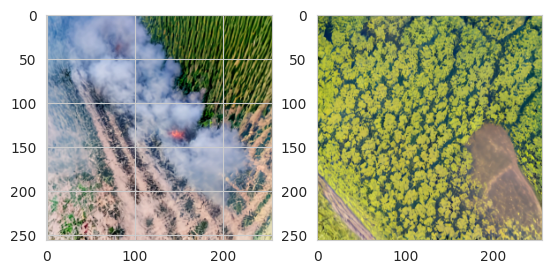

In [38]:
plt.subplot(121)
plt.imshow(images_with_fire[0])
plt.subplot(122)
plt.grid(False)
plt.imshow(images_without_fire[0])

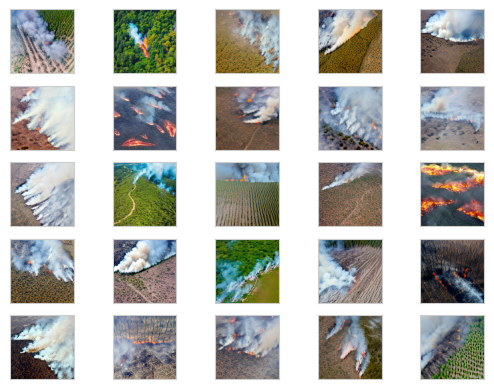

In [7]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_with_fire[i])

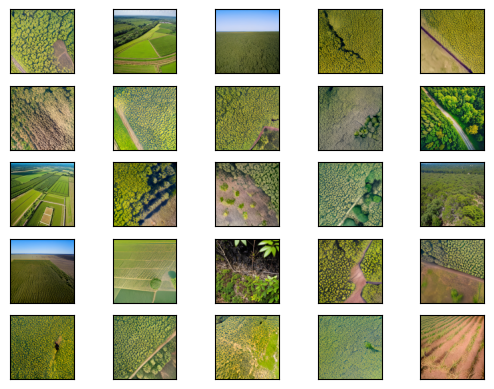

In [7]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_without_fire[i])

In [6]:
concatenated_images = np.concatenate((images_with_fire, images_without_fire), axis=0)
concatenated_labels = np.concatenate((y_with_fire, y_without_fire), axis=0)
print(concatenated_images.shape, concatenated_labels.shape)

(199, 256, 256, 3) (199,)


In [7]:
def generate_more_images(images, labels):
    values_to_flip = [0, 1, -1]

    height, width = images.shape[1:3]
    cx, cy = (height//2, width//2)
    thetas = [90, 180]
    new_images = []
    new_labels = []
    for image, label in zip(images, labels):
        new_images.append(image)
        new_labels.append(label)
        for i in range(len(values_to_flip)):
            img_flipped = cv2.flip(image, values_to_flip[i])
            new_images.append(img_flipped)
            new_labels.append(label)
        for j in range(len(thetas)):
            M = cv2.getRotationMatrix2D((cx, cy), thetas[j], 1.0)
            img_rotated = cv2.warpAffine(image, M, (image.shape[0], image.shape[1]))
            new_images.append(img_rotated)
            new_labels.append(label)

    return np.array(new_images), np.array(new_labels)


In [8]:
all_images, all_labels = generate_more_images(concatenated_images, concatenated_labels)

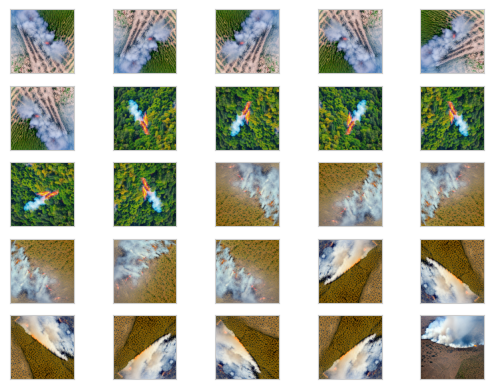

In [42]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(all_images[i])

In [9]:
all_images.shape

(1194, 256, 256, 3)

## Save images in directory

In [44]:
def save_images(all_images, all_labels, path):
    print(all_images.shape)
    print(all_labels.shape)
    for i in range(all_images.shape[0]):
        if all_labels[i] == 1:
            all_path = f'database-generated/{path}/yes_fire/{i}.png'
        else:
            all_path = f'database-generated/{path}/no_fire/{i}.png'
        cv2.imwrite(all_path, bgr2rgb(all_images[i]))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=11)

In [46]:
X_train_final, X_validation, y_train_final, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=11)

(array([118.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 121.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

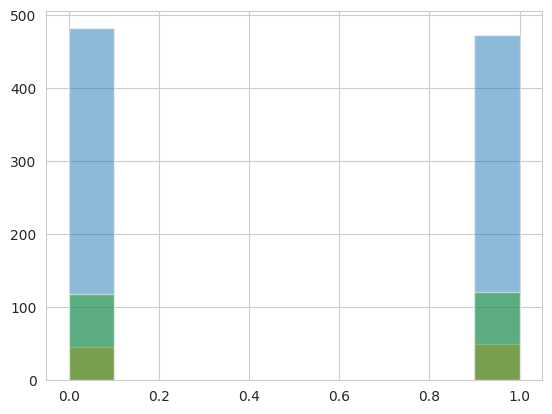

In [47]:
plt.hist(y_train, alpha=0.5)
plt.hist(y_validation, alpha=0.5)
plt.hist(y_test, alpha=0.5)

In [48]:
save_images(X_train_final, y_train_final, 'train')
save_images(X_validation, y_validation, 'validation')
save_images(X_test, y_test, 'test')

(859, 256, 256, 3)
(859,)
(96, 256, 256, 3)
(96,)
(239, 256, 256, 3)
(239,)


# Generate Model

In [4]:
datagen = ImageDataGenerator(rescale=1/255.)
batch_size = 8

In [47]:
train_generator = datagen.flow_from_directory(
    './database-generated/train',
    target_size=(256,256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
validation_generator = datagen.flow_from_directory(
    './database-generated/validation',
    target_size=(256,256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_directory(
    './database-generated/test',
    target_size=(256,256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 859 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 239 images belonging to 2 classes.


In [8]:
def show_images(generator, batch_size):
    rows = 2
    fig, axes = plt.subplots(rows,batch_size)
    class_list = ['no fire', 'fire']
    for r in range(rows):
        #---get the batch of augmented images---
        image_batch = generator.next()
        #---get the number of images returned---
        images_count = image_batch[0].shape[0]
        for c in range(images_count):
            #---convert to unsigned integers for viewing---
            image = image_batch[0][c]

            #---display the image---
            axes[r,c].imshow(image, vmin=0, vmax=1)
            #---display the label of the image---
            axes[r,c].title.set_text(
                class_list[image_batch[1][c].astype(np.int8)])
            #---hides the x and y-ticks---
            axes[r,c].set_xticks([])
            axes[r,c].set_yticks([])

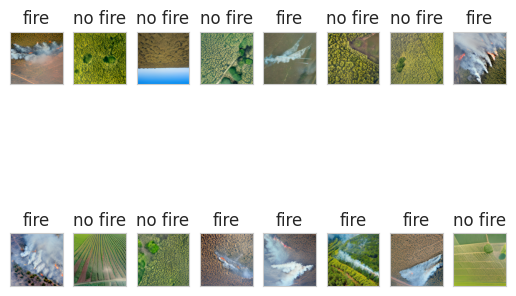

In [9]:
show_images(train_generator, batch_size)

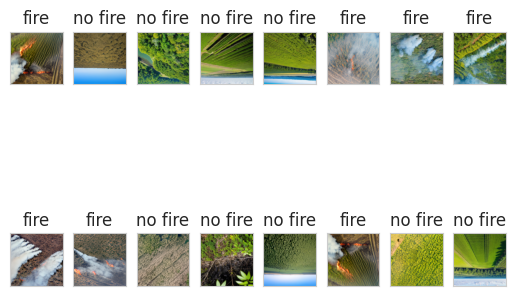

In [54]:
show_images(validation_generator, batch_size)

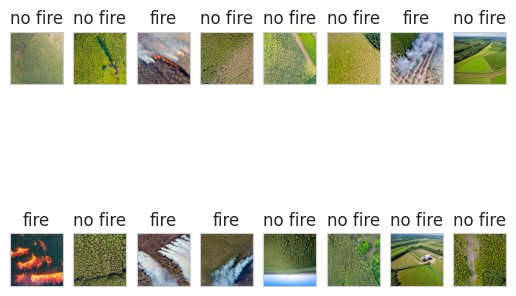

In [55]:
show_images(test_generator, batch_size)

In [125]:
model = Sequential()

# model.add(Lambda(lambda image: tf.image.resize_images(image, size_images, method=tf.image.ResizeMethod.AREA, preserve_aspect_ratio = True)))
model.add(Conv2D(
    input_shape=(256, 256, 3),
    filters=32,
    kernel_size=(3,3),
    activation='relu')
)
model.add(MaxPool2D(2, 2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 30, 30, 128)    

In [126]:
LOSS = 'binary_crossentropy'
OPTIMIZER = 'adam'

# Compile the model
model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=['accuracy'])

In [88]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)

In [127]:
NUM_EPOCHS = 5

In [128]:
# Fit the model
step_size_train = train_generator.n // train_generator.batch_size
step_size_validation = validation_generator.n // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch = step_size_train,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=step_size_validation,
    # callbacks=[early_stop]
)

Epoch 1/5


2023-05-19 20:03:11.246125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


107/107 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8989

2023-05-19 20:03:36.408009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


107/107 [==============================] - 26s 237ms/step - loss: 0.2637 - accuracy: 0.8989 - val_loss: 0.1474 - val_accuracy: 0.9583
Epoch 2/5
107/107 [==============================] - 25s 237ms/step - loss: 0.1414 - accuracy: 0.9553 - val_loss: 0.2884 - val_accuracy: 0.9167
Epoch 3/5
107/107 [==============================] - 25s 235ms/step - loss: 0.1255 - accuracy: 0.9553 - val_loss: 0.1340 - val_accuracy: 0.9375
Epoch 4/5
107/107 [==============================] - 25s 235ms/step - loss: 0.0672 - accuracy: 0.9694 - val_loss: 0.1040 - val_accuracy: 0.9688
Epoch 5/5
107/107 [==============================] - 25s 231ms/step - loss: 0.1333 - accuracy: 0.9530 - val_loss: 0.1450 - val_accuracy: 0.9583


## Avaliando Modelo

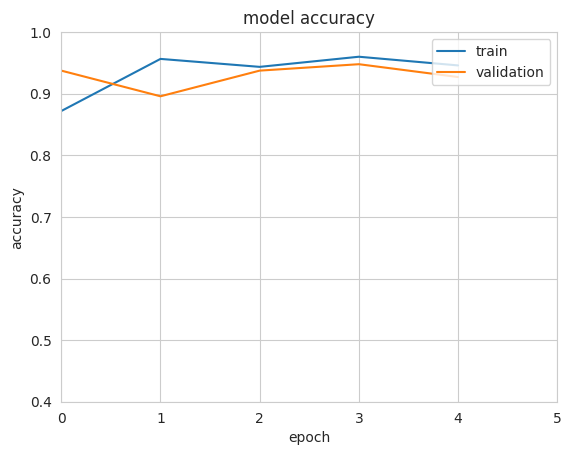

In [97]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.xlim([0,len(history.history['accuracy'])])
plt.ylim([0.4,1.0])
plt.show()

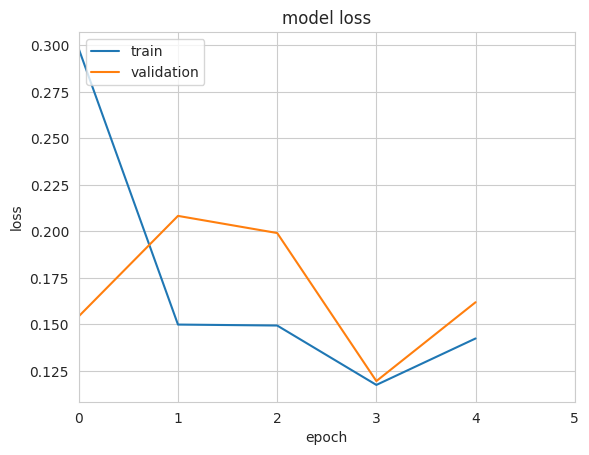

In [98]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xlim([0,len(history.history['loss'])])
plt.show()

In [35]:
print("Train data: ", model.evaluate(train_generator, steps=step_size_train)[1])
print("Eval data: ", model.evaluate(validation_generator, steps=step_size_validation)[1])
print("Test data: ", model.evaluate(X_test, y_test)[1])

  3/107 [..............................] - ETA: 4s - loss: 0.0242 - accuracy: 1.0000

2023-05-19 18:57:37.373179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


107/107 [==============================] - 5s 47ms/step - loss: 0.0711 - accuracy: 0.9755
Train data:  0.9754672646522522
 3/12 [======>.......................] - ETA: 0s - loss: 0.1227 - accuracy: 0.9583

2023-05-19 18:57:42.487012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 1s 49ms/step - loss: 0.1271 - accuracy: 0.9688
Eval data:  0.96875


NameError: name 'X_test' is not defined

In [129]:
print("Test data: ", model.evaluate(test_generator, steps=test_generator.n//test_generator.batch_size + 1)[1])

 3/30 [==>...........................] - ETA: 1s - loss: 0.0793 - accuracy: 1.0000

2023-05-19 20:05:27.411929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 2s 50ms/step - loss: 0.0740 - accuracy: 0.9791
Test data:  0.9790794849395752


In [39]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [137]:
predictions = model.predict(test_generator, steps=test_generator.n//test_generator.batch_size + 1)
predictions.shape

 1/30 [>.............................] - ETA: 3s

2023-05-19 20:08:17.530335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 2s 51ms/step


(239, 1)

In [138]:
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

In [102]:
from sklearn.metrics import classification_report,confusion_matrix

In [103]:
class_list = ['no fire', 'fire']
print(classification_report(test_generator.classes, predictions, target_names=class_list))

              precision    recall  f1-score   support

     no fire       0.98      0.86      0.91       118
        fire       0.88      0.98      0.93       121

    accuracy                           0.92       239
   macro avg       0.93      0.92      0.92       239
weighted avg       0.93      0.92      0.92       239



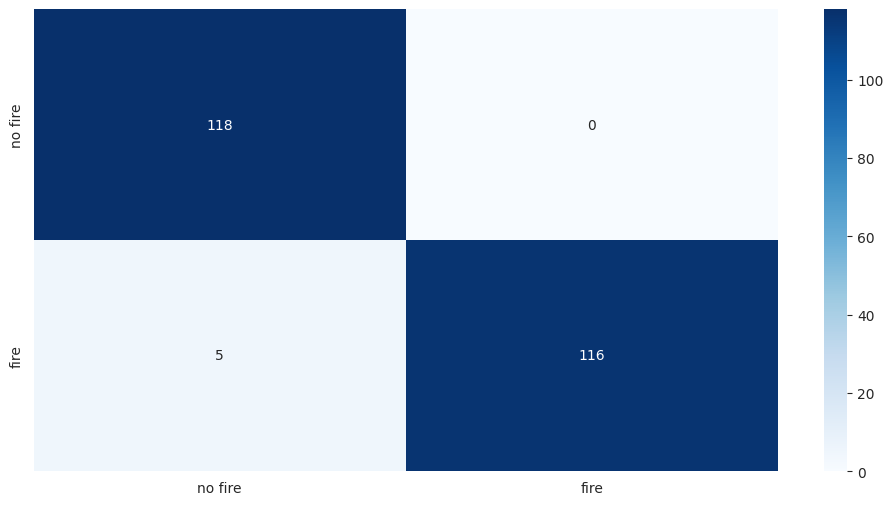

In [139]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(confusion_matrix(test_generator.classes,predictions), cmap='Blues', annot=True, fmt='g', xticklabels=class_list, yticklabels=class_list);

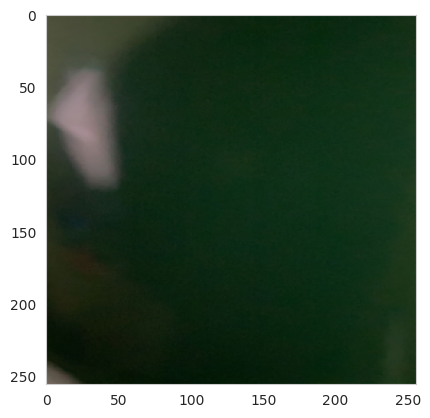

In [134]:
img = cv2.imread('./cel-photos/no_fire/4.jpeg',  cv2.IMREAD_COLOR)
# img = cv2.imread('./database-generated/test/no_fire/0.png',  cv2.IMREAD_COLOR)
img = bgr2rgb(img)

img = cv2.resize(img, (size_images[1], size_images[0]), interpolation=cv2.INTER_AREA)

plt.imshow(img)
plt.grid(False)

In [33]:
img.shape

(256, 256, 3)

In [135]:
predict = model.predict(np.array([img]))
print(predict)

1/1 [==============================] - 0s 24ms/step
[[0.02154833]]


# Salvando Modelo

In [140]:
model.save('./model_saved')

INFO:tensorflow:Assets written to: ./model_saved/assets


INFO:tensorflow:Assets written to: ./model_saved/assets


In [141]:
# Convert TF model to a tflite model
from tensorflow.keras.models import load_model

model_mask_detection = load_model('model_saved')
converter = tf.lite.TFLiteConverter.from_keras_model(model_mask_detection)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_size = open("model_saved.tflite","wb").write(tflite_model)
print("Quantized model (DEFAULT) is {:,} bytes".format(tflite_model_size))

INFO:tensorflow:Assets written to: /tmp/tmp13nz8dhk/assets


INFO:tensorflow:Assets written to: /tmp/tmp13nz8dhk/assets


Quantized model (DEFAULT) is 14,849,792 bytes


2023-05-19 20:09:01.258759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-19 20:09:01.258778: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-19 20:09:01.259295: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp13nz8dhk
2023-05-19 20:09:01.260067: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-19 20:09:01.260077: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp13nz8dhk
2023-05-19 20:09:01.262994: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-19 20:09:01.263612: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-19 20:09:01.300124: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp13nz8dhk
2023-05